# Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
sys.path.append('../src')

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

from data   import train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

## Setup

In [48]:
DATASET_PATH = '../datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'ds','mwh':'y'},inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


Datos desglosado de demanda de grandes usuarios y distribuidores de energia. Solo esta disponible acumulado mensual 

http://datos.energia.gob.ar/dataset/publicaciones-cammesa/archivo/30e1c42d-44a7-428f-a55a-12c81dc14186

#### Comparativa entre dataset mensual y el dataset original

In [49]:
DATASET_PATH = '../datasets/demanda-historica.csv'
demanda= pd.read_csv(DATASET_PATH,parse_dates=['indice_tiempo']) # hay datos repetidos entre 2017 y 2020

print('regiones:',demanda.region.unique())
print('categoria_demanda:',demanda.categoria_demanda.unique())
print('tipo_agente:',demanda.tipo_agente.unique())
#demanda.columns = dataset.columns.str.lower()

demanda.rename(columns={'indice_tiempo':'ds','demanda_MWh':'demanda'},inplace=True)

demanda.head()

regiones: ['GRAN BS.AS.' 'BUENOS AIRES' 'LITORAL' 'CUYO' 'PATAGONICA' 'NORESTE'
 'COMAHUE' 'NOROESTE' 'CENTRO']

categoria_demanda: ['Gran Usuario' 'Distribuidor']

tipo_agente: ['GU' 'AG' 'DI' 'AR']

,anio,mes,agente_nemo,agente_descripcion,tipo_agente,region,provincia,categoria_area,categoria_demanda,tarifa,categoria_tarifa,demanda,ds
0,2012,1,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2222.628,2012-01-01
1,2012,1,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,536.858,2012-01-01
2,2012,1,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,336.297,2012-01-01
3,2012,1,ACINROSY,ACINDAR ROSARIO EX-NAVARRO,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,601.066,2012-01-01
4,2012,1,ACINTBOY,ACINDAR PTA. TABLADA,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,3076.618,2012-01-01


In [14]:
demanda_gba=demanda[(demanda.categoria_demanda=='Distribuidor') & 
                    #(demanda.categoria_demanda=='Gran Usuario')&
                    (demanda.region=='GRAN BS.AS.')
                    #& (demanda.tipo_agente=='GU') 
                    & (demanda.agente_nemo!='EDELAPID')  #edenor y edesur
                    & (demanda.agente_descripcion!='YPF REFINERIA LA PLATA')
                    ]
demanda_gba.head()

,anio,mes,agente_nemo,agente_descripcion,tipo_agente,region,provincia,categoria_area,categoria_demanda,tarifa,categoria_tarifa,demanda,ds
652,2012,1,EDENOROD,EDENOR DISTRIBUIDOR,DI,GRAN BS.AS.,BUENOS AIRES,Edenor,Distribuidor,Alumbrado Publico,Residencial,52975.763,2012-01-01
653,2012,1,EDENOROD,EDENOR DISTRIBUIDOR,DI,GRAN BS.AS.,BUENOS AIRES,Edenor,Distribuidor,GRANDES USUARIOS C DEM MAYOR O IGUAL 300KW,Industrial/Comercial Grande,195106.632,2012-01-01
654,2012,1,EDENOROD,EDENOR DISTRIBUIDOR,DI,GRAN BS.AS.,BUENOS AIRES,Edenor,Distribuidor,MENOR 10KW NO RES. MAYOR O IGUAL 4000 KWH/BIM,Comercial,46675.208,2012-01-01
655,2012,1,EDENOROD,EDENOR DISTRIBUIDOR,DI,GRAN BS.AS.,BUENOS AIRES,Edenor,Distribuidor,MENOR 10KW NO RES. MENOR 4000 KWH BIM,Comercial,138687.688,2012-01-01
656,2012,1,EDENOROD,EDENOR DISTRIBUIDOR,DI,GRAN BS.AS.,BUENOS AIRES,Edenor,Distribuidor,RES. MAYOR 1000 Y MENOR O IGUAL 1400 KWH BIM,Residencial,129618.168,2012-01-01


In [15]:
demanda_mensual=demanda_gba[['demanda','ds']].groupby('ds').sum()
demanda_mensual.reset_index(inplace=True)

dataset_mensual = dataset.groupby(pd.Grouper(key='ds', freq='1M')).sum()
#dataset_mensual=dataset[['y','ds']].groupby('ds').sum()
dataset_mensual.reset_index(inplace=True)
#dataset_mensual.ds.dt.day=1
dataset_mensual.ds=dataset_mensual.ds.apply(lambda dt: dt.replace(day=1))
dataset_mensual = dataset_mensual[(dataset_mensual.ds>='2011-12-31') & ((dataset_mensual.ds<'2020-02-01'))]

<Figure size 432x288 with 2 Axes>

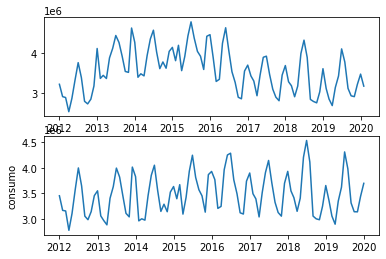

[<matplotlib.lines.Line2D object at 0x7f5506ff7790>]

<Figure size 432x288 with 1 Axes>

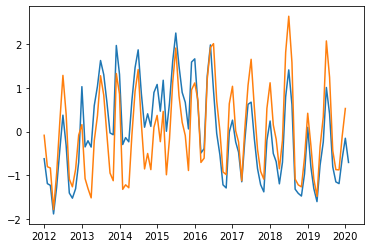

In [16]:
fig, axs = plt.subplots(2)
#fig.suptitle('datos_mensuales')
axs[0].plot(demanda_mensual.ds,demanda_mensual.demanda)
plt.ylabel('consumo GU')
axs[1].plot(dataset_mensual.ds,dataset_mensual.y)
plt.ylabel('consumo')
plt.show() 

plt.plot(demanda_mensual.ds,(demanda_mensual.demanda-demanda_mensual.demanda.mean())/demanda_mensual.demanda.std())#, label='demanda GU')
plt.plot(dataset_mensual.ds,(dataset_mensual.y-dataset_mensual.y.mean())/dataset_mensual.y.std()) #consumo total

En la página del ministerio de energía menciona en varios informes que el consumo eléctrico tiene una marcada componente semestral, ya que en verano aumenta el consumo residencial para refrigeración y en invierno el consumo en industrias.

## Functions

In [17]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(10,6)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

In [18]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

In [19]:
#funciones para ploteo estacional, básico y períodograma
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
#%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [20]:
#lags
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

## Preprocessing

In [21]:
train_set, test_set = train_test_split(dataset,0.10095)
N_test=len(test_set)

Acoto desde 2012 en adelante ya que las oscilaciones se ven de amplitud mas constante. Al observar los años 2006-2011 parecen ir creciendo la tendencia de consumo de energía.

In [22]:
train_set=train_set[train_set.ds>'12-31-2011'] #ultimo dia train 31/12/2019
train_set.reset_index(inplace=True)

Text(0.5, 1.0, 'train 2012-2019')

<Figure size 432x288 with 1 Axes>

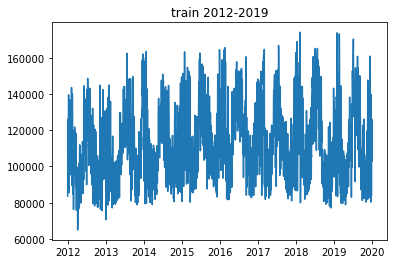

In [23]:
plt.plot(train_set.ds,train_set.y)
plt.title('train 2012-2019')

Text(0.5, 1.0, 'test 2020-2021')

<Figure size 432x288 with 1 Axes>

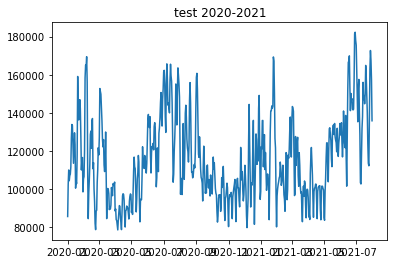

In [24]:
plt.plot(test_set.ds,test_set.y)
plt.title('test 2020-2021')

## Análisis de estacionalidad

referencias de las siguientes funciones: https://www.kaggle.com/learn/time-series

### Filtros de media movil

#### Trend (anual)

<Figure size 432x288 with 1 Axes>

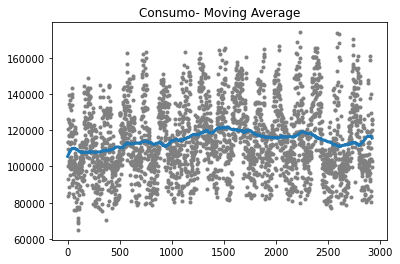

In [25]:
size_window=365

moving_average = train_set.y.rolling(
    window=size_window,          # day window
    center=True,                 # puts the average at the center of the window
    min_periods=size_window//2,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train_set.y.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Consumo- Moving Average", legend=False,
);

Text(0.5, 1.0, 'restando la media movil')

<Figure size 432x288 with 1 Axes>

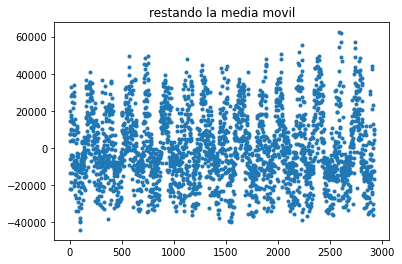

In [26]:
plt.plot(train_set.y-moving_average,'.')
plt.title('restando la media movil')

#### Se pone filtro de media móvil mensual para atenuar las frecuencias semanales y diarias  

<Figure size 432x288 with 1 Axes>

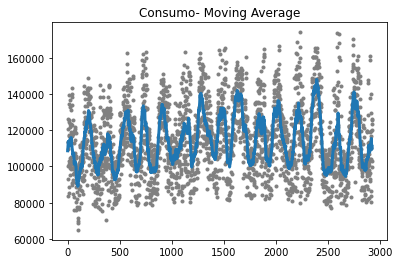

In [27]:
size_window=30

moving_average = train_set.y.rolling(
    window=size_window,          # day window
    center=True,                 # puts the average at the center of the window
    min_periods=size_window//2,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train_set.y.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Consumo- Moving Average", legend=False,
);

Si se compara el resultado de aplicar el filtro de media móvil mensual con el acumulado de consumo por mes se obtiene la sigte. figura. Se aprecia que empieza a aparecer más notablemente la periodicidad similar al consumo mensual. Habría que mejorar la respuesta a este filtro con un filtro digital.
Se aprecia periodicidad semestral.

[<matplotlib.lines.Line2D object at 0x7f5506dfa3b0>]

<Figure size 432x288 with 1 Axes>

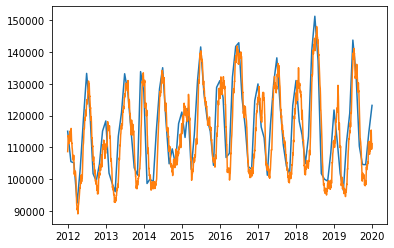

In [28]:
plt.plot(dataset_mensual.ds,dataset_mensual.y/30)
plt.plot(train_set.ds,moving_average)

### Seasonality

In [29]:
X = train_set.copy()

X['date'] = pd.to_datetime(X['ds'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['week'] = X['date'].dt.isocalendar().week
X['day_month'] = X['date'].dt.day
X['day_year'] = X['date'].dt.dayofyear 
X['day'] = X['date'].dt.dayofweek 
#X['weekend']=(X['day_week']>5).astype(int)
#X['friday']=(X['day_week']==4).astype(int)
#X["week"] = X.index.week
bins = [0, 91, 183, 275, 366]  #estaciones
labels=['Winter', 'Spring', 'Summer', 'Fall'] #hemisferio norte
labels=['Summer', 'Fall','Winter', 'Spring'] #hemisferio sur
doy = X.day_year
X['season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)
X.reset_index(inplace=True)

#### Frecuencias detectadas en el conjunto de train

En el periodgrama se ve un pico máximo en la frecuencia semianual, la segunda componente es bisemanal (cada 2 semanas).

/var/tmp/ipykernel_692974/3699215712.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(X.y);


<Figure size 432x288 with 1 Axes>

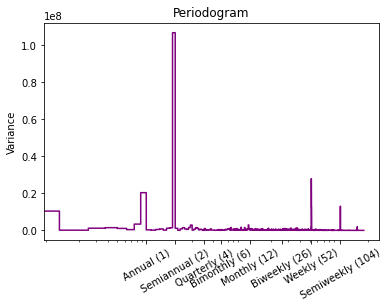

In [30]:
plot_periodogram(X.y);

#### Consumo medio mensual en cada año

En la figura siguiente se aprecia que la media de año a año va creciendo hasta 2018. En 2019 descienden un poco los valores medios.
Se aprecia que los máximos se producen en los meses 6-7, los meses 4 y 11 son los menores y los meses 1 y 12 vuelven a tener consumos altos (menores que julio dependiendo el año).

<Figure size 432x288 with 1 Axes>

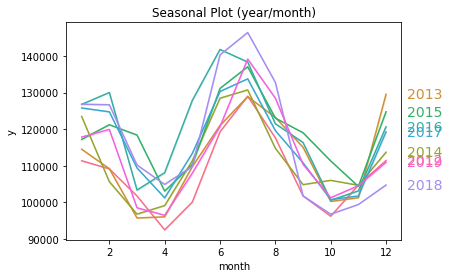

In [31]:
seasonal_plot(X, y='y', period='year', freq='month');

<AxesSubplot:xlabel='month', ylabel='y'>

<Figure size 432x288 with 1 Axes>

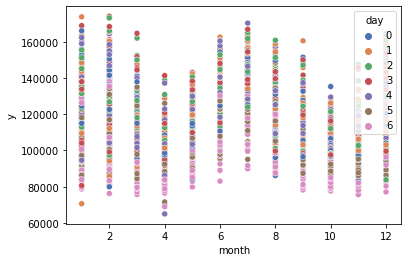

In [32]:
sns.scatterplot(data=X, x="month", y='y', hue="day",palette="deep")

<Figure size 432x288 with 1 Axes>

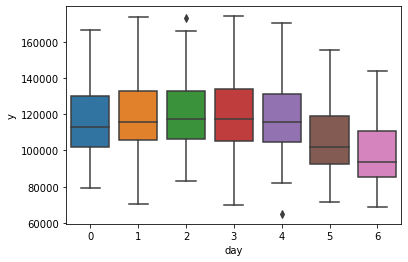

In [33]:
ax = sns.boxplot(x="day", y="y", data=X)

0 - Lunes, Sábado y domingo hay menos consumo energético. Se podría agregar variable de si es Weekend. 

### Lags

In [34]:
#X.reset_index(inplace=True)
X.set_index(
    pd.PeriodIndex(X.date, freq="W"),
    inplace=True,
)
X.drop("date", axis=1, inplace=True)

In [ ]:
_ = plot_lags(X.y, lags=16, nrows=4)
_ = plot_pacf(X.y, lags=16)

X.reset_index(inplace=True)

Los lag plots indican que la relación de y con sus lags es mayormente linear. La autocorrelation parcial es alta en lag 1, 6, 8, 15, 22,28

#### Analisis de temperatura

Esta es fácil  ;-)

En la siguiente figura se aprecia que la media de temperatura es bastante similar en los distintos meses de cada año. El año que registro menores temperaturas fue 2007.

In [ ]:
seasonal_plot(X, y='tmp', period='year', freq='month');

In [ ]:
plot_periodogram(X.tmp);

La periodicidad mayor se registra de forma anual, por lo que el análisis es consistente.

# Model Definition

In [142]:
temperatura = pd.DataFrame(train_set[['ds','tmp']])
model = Prophet(
    interval_width    = 0.99,
    daily_seasonality = False,
    weekly_seasonality =False,
               )
model.add_regressor('tmp')

#model.add_seasonality(name='weekly', period=7, fourier_order=4)
#model.add_seasonality(name='semi-weekly', period=3.5, fourier_order=4)
#model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
#model.add_seasonality('semi-annualy', period=182.5, fourier_order=4, mode='additive')

#model.add_regressor('regressor', mode='additive')
#model.add_seasonality(name='anual',period=365,fourier_order=4)
model.fit(train_set)

#fig=predict(model, test_set, N_test)

16:33:43 - cmdstanpy - INFO - Chain [1] start processing
16:33:44 - cmdstanpy - INFO - Chain [1] done processing


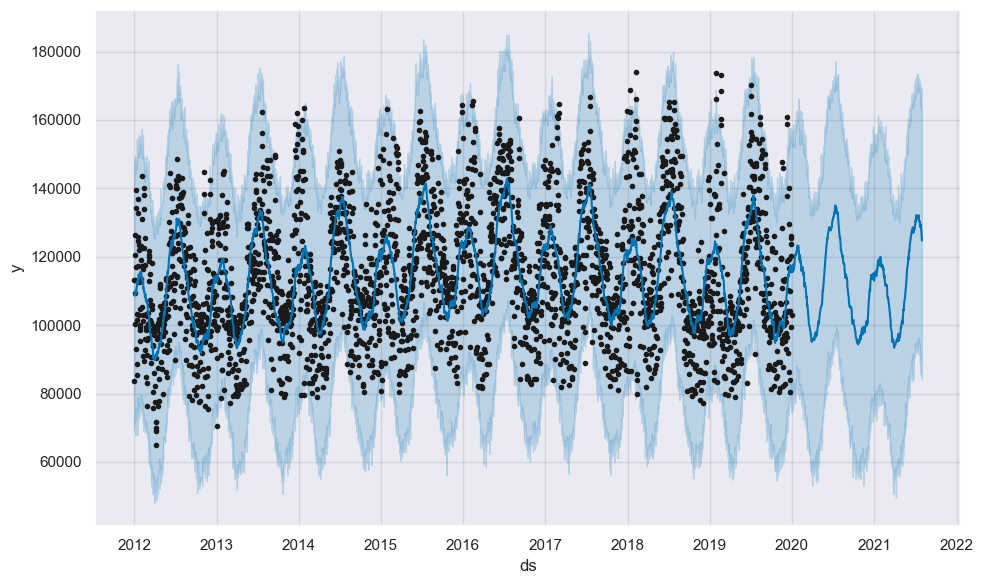

In [143]:
future = model.make_future_dataframe(periods=N_test)
future['tmp']=dataset.tmp
                                                         
forecast = model.predict(future)
fig=model.plot(forecast)

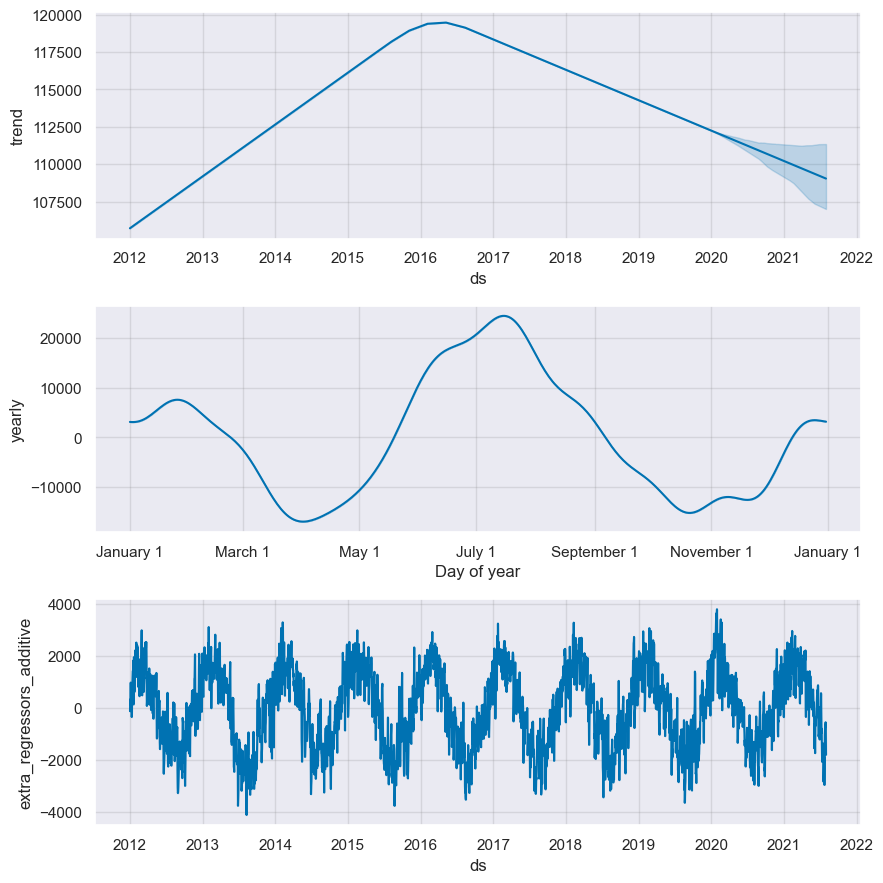

In [144]:
fig=model.plot_components(forecast)

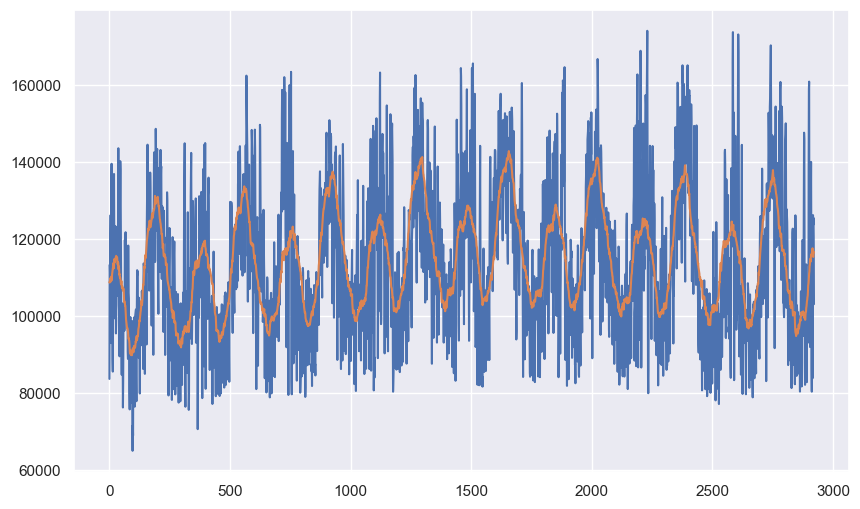

In [145]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])
plt.plot(train_set.y)
plt.plot(y_fore_train)

In [146]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               3500 non-null   datetime64[ns]
 1   trend                            3500 non-null   float64       
 2   yhat_lower                       3500 non-null   float64       
 3   yhat_upper                       3500 non-null   float64       
 4   trend_lower                      3500 non-null   float64       
 5   trend_upper                      3500 non-null   float64       
 6   additive_terms                   3500 non-null   float64       
 7   additive_terms_lower             3500 non-null   float64       
 8   additive_terms_upper             3500 non-null   float64       
 9   extra_regressors_additive        3500 non-null   float64       
 10  extra_regressors_additive_lower  3500 non-null   float64    

Amplio dataset a partir de la fecha

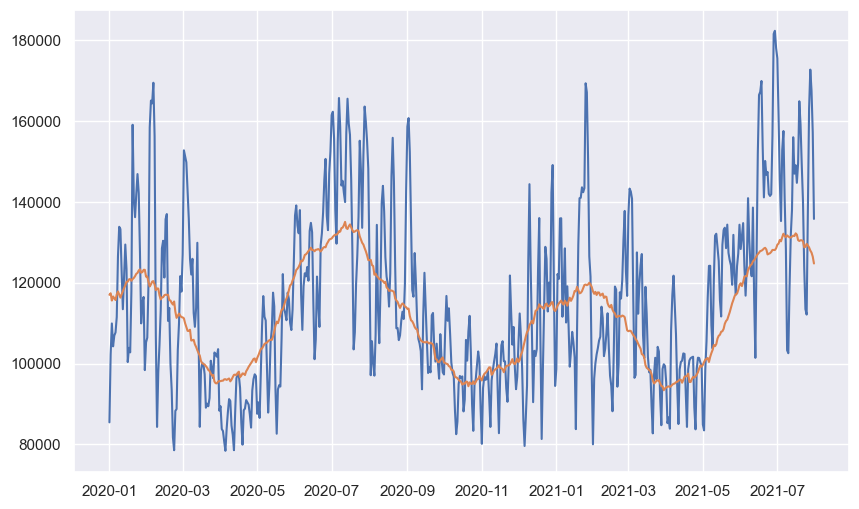

In [147]:
plt.plot(test_set.ds,test_set.y)
plt.plot(test_set.ds,y_fore_future)

muy mejorable !

### Prophet para temperatura

C:\Users\Flavia\AppData\Local\Temp\ipykernel_16088\435101446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_tmp.rename(columns={'tmp':'y'},inplace=True)
C:\Users\Flavia\AppData\Local\Temp\ipykernel_16088\435101446.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_tmp.rename(columns={'tmp':'y'},inplace=True)
16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing


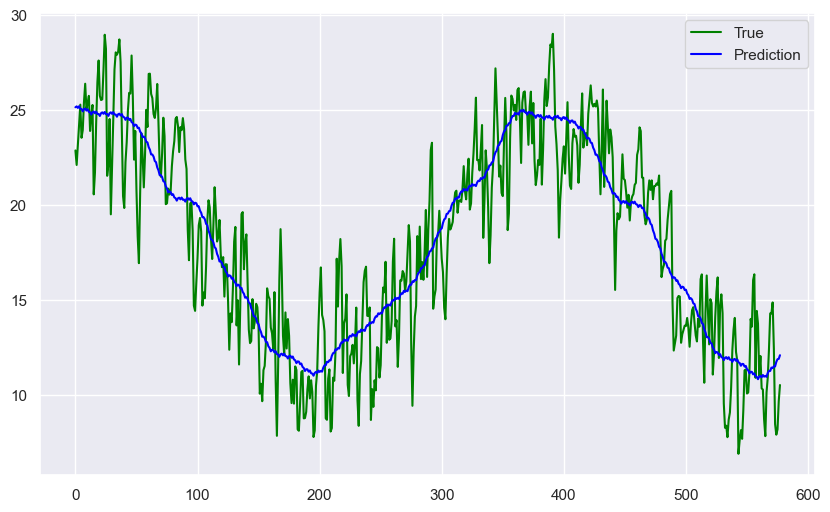

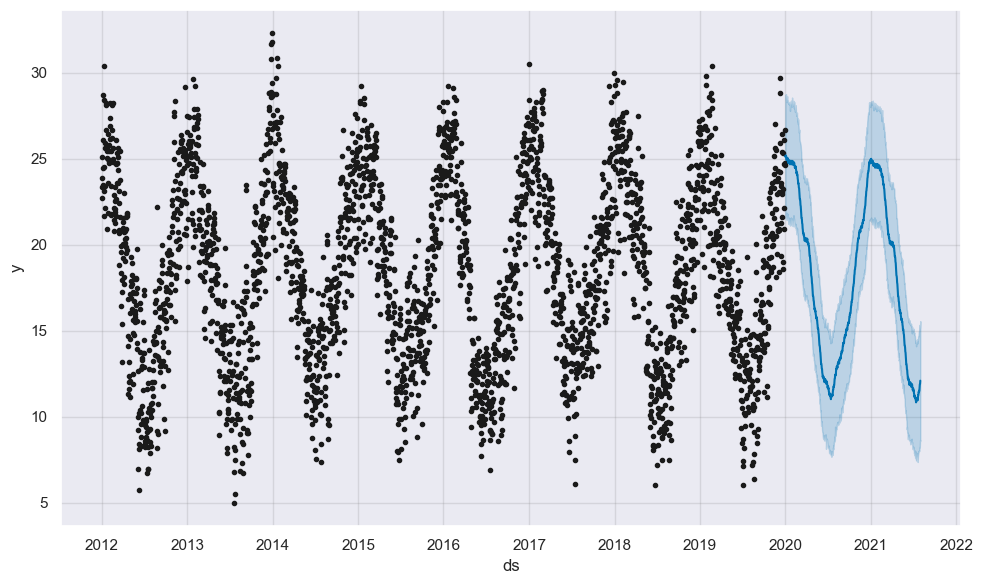

In [139]:
#model.add_seasonality(name='weekly', period=7, fourier_order=4)
#model.add_seasonality(name='semi-weekly', period=3.5, fourier_order=4)
#model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
#model.add_seasonality('semi-annualy', period=182.5, fourier_order=4, mode='additive')

#model.add_regressor('regressor', mode='additive')
#model.add_seasonality(name='anual',period=365,fourier_order=4)
train_set_tmp=train_set[['ds','tmp']]
train_set_tmp.rename(columns={'tmp':'y'},inplace=True)

test_set_tmp=test_set[['ds','tmp']]
test_set_tmp.rename(columns={'tmp':'y'},inplace=True)
model = Prophet()

model.fit(train_set_tmp)

fig=predict(model, test_set_tmp, N_test)

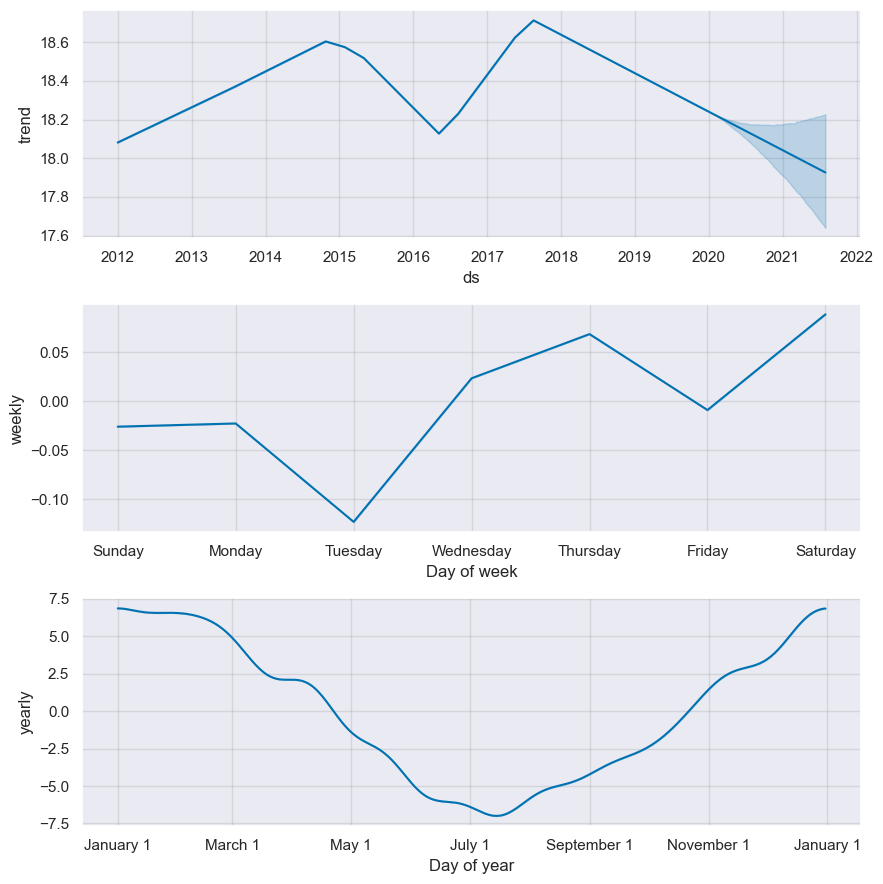

In [141]:
future = model.make_future_dataframe(periods=N_test)
forecast = model.predict(future)
#fig=model.plot(forecast)
fig=model.plot_components(forecast)